In [1]:
!pip install segmentation-models-3D

In [1]:
!pip install patchify

In [2]:
import tensorflow as tf
import keras

print(tf.__version__)
print(keras.__version__)

2.8.0
2.8.0


In [3]:
import sys
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
from patchify import unpatchify
from tensorflow.keras.models import load_model
from sklearn.preprocessing import MinMaxScaler

In [4]:
import segmentation_models_3D as sm

Segmentation Models: using `tf.keras` framework.


In [5]:
# Get test set
test_original_3D = np.load('/Users/yichunsun/Desktop/TFM/Data/3D/3D_npy_files/3D_test_original.npy')
test_mask_3D = np.load('/Users/yichunsun/Desktop/TFM/Data/3D/3D_npy_files/3D_test_mask.npy')

In [47]:
# Or Windowing
test_original_3D = np.load('/Users/yichunsun/Desktop/TFM/Data/3D/3D_npy_files/testo_w6.npy')
test_mask_3D = np.load('/Users/yichunsun/Desktop/TFM/Data/3D/3D_npy_files/3D_test_mask.npy')

In [6]:
# Back to 512x512x64
original_patches_reshaped = np.reshape(test_original_3D[:,:,:,:,0],
                                        (4, 4, 1, 128, 128, 64) )
mask_patches_reshaped = np.reshape(test_mask_3D[:,:,:,:,0],
                                        (4, 4, 1, 128, 128, 64) )
reconstructed_original = unpatchify(original_patches_reshaped, (512,512,64))
reconstructed_mask = unpatchify(mask_patches_reshaped, (512,512,64))

In [7]:
# Prediction DICE
def dice_coefficient(y_true, y_pred):
    intersection = np.sum(y_true * y_pred)
    union = np.sum(y_true) + np.sum(y_pred)

    dice = (2.0 * intersection) / (union + 1e-8)
    return dice

In [8]:
# Normalization for original 3D unet model
scaler = MinMaxScaler()
test_original_ori = scaler.fit_transform(test_original_3D.reshape(-1, test_original_3D.shape[-1])).reshape(test_original_3D.shape)

In [9]:
model_ori = load_model('/Users/yichunsun/Desktop/TFM/Data/3D/3D_model/vanilla_unet3d_totalLoss.h5', compile=False)

2023-12-19 06:14:05.630098: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [50]:
# Windowing
model_ori = load_model('/Users/yichunsun/Desktop/TFM/Data/3D/3D_model/vanilla_unet3d_window6.h5', compile=False)

In [11]:
# Noise (data augmentation)
model_ori = load_model('/Users/yichunsun/Desktop/TFM/Data/3D/3D_model/vanilla_unet3d_totalLoss_noise.h5', compile=False)

In [10]:
ori_prediction = model_ori.predict(test_original_ori[:,:,:,:,0])

In [11]:
binary_ori = (ori_prediction > 0.5).astype(int)

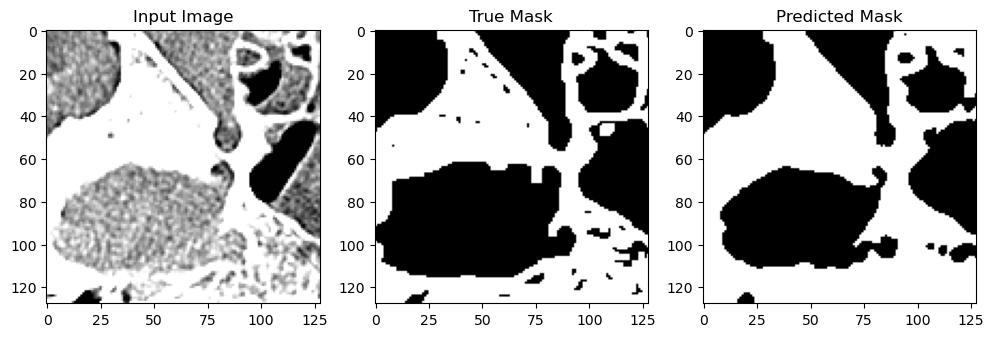

In [53]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

axes[0].imshow(test_original_3D[5,:,:,43,0], cmap='gray')
axes[0].set_title('Input Image')

axes[1].imshow(test_mask_3D[5,:,:,43,0], cmap='gray')
axes[1].set_title('True Mask')

axes[2].imshow(binary_ori[5,:,:,43,0], cmap='gray')
axes[2].set_title('Predicted Mask')
    
plt.show()

In [12]:
ori_patches_reshaped = np.reshape(binary_ori[:,:,:,:,0],
                                        (4, 4, 1, 128, 128, 64))
ori_reconstructed = unpatchify(ori_patches_reshaped, (512,512,64))

In [56]:
for sample_idx in range(64):
    fig, axes = plt.subplots(1, 3, figsize=(12, 4))

    axes[0].imshow(reconstructed_original[:,:,sample_idx], cmap='gray')
    axes[0].set_title('Input Image')

    axes[1].imshow(reconstructed_mask[:,:,sample_idx], cmap='gray')
    axes[1].set_title('True Mask')

    axes[2].imshow(ori_reconstructed[:,:,sample_idx], cmap='gray')
    axes[2].set_title('Predicted Mask')

    #save_dir = '/Users/yichunsun/Desktop/TFM/Data/3D/Results/PredictResult/Unet3D' 
    save_dir = '/Users/yichunsun/Desktop/TFM/Data/3D/Results/PredictResult/ONLYVANILA'
    os.makedirs(save_dir, exist_ok=True)

    plt.savefig(os.path.join(save_dir, f'Test_Unet3D_slice_{sample_idx}.png'))
    plt.close()

In [13]:
D_ori = dice_coefficient(reconstructed_mask, ori_reconstructed)
print("DICE of using the original structure of Unet 3D:", D_ori)

DICE of using the original structure of Unet 3D: 0.8832356827158959


In [8]:
# Normalization for unet with resnet50 encoder model
preprocess_resn = sm.get_preprocessing('resnet50')
test_original_resn = preprocess_resn(test_original_3D)

In [9]:
model_resn = load_model('/Users/yichunsun/Desktop/TFM/Data/3D/3D_model/m_resnet50_totalLoss.h5', compile=False)

2023-12-10 22:41:44.757004: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [19]:
# Noise
model_resn = load_model('/Users/yichunsun/Desktop/TFM/Data/3D/3D_model/m_resnet50_totalLoss_noise.h5', compile=False)

In [10]:
resn_prediction = model_resn.predict(test_original_resn)

In [11]:
binary_resn = (resn_prediction > 0.5).astype(int)

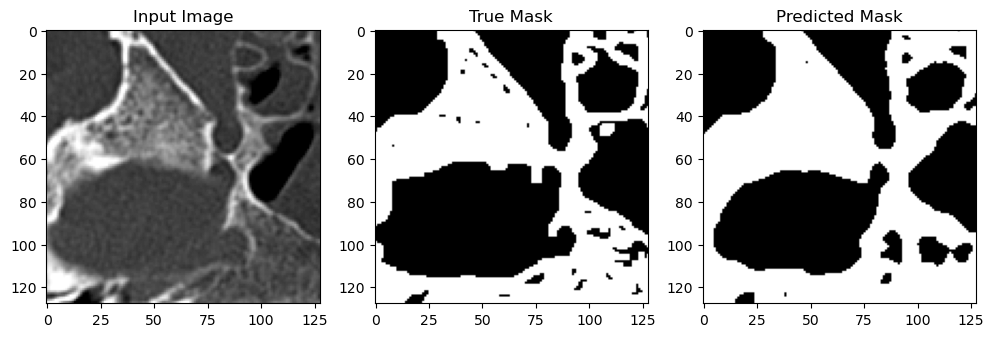

In [20]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

axes[0].imshow(test_original_3D[5,:,:,43,0], cmap='gray')
axes[0].set_title('Input Image')

axes[1].imshow(test_mask_3D[5,:,:,43,0], cmap='gray')
axes[1].set_title('True Mask')

axes[2].imshow(binary_resn[5,:,:,43,0], cmap='gray')
axes[2].set_title('Predicted Mask')
    
plt.show()

In [12]:
resn_patches_reshaped = np.reshape(binary_resn[:,:,:,:,0],
                                        (4, 4, 1, 128, 128, 64))
resn_reconstructed = unpatchify(resn_patches_reshaped, (512,512,64))

In [14]:
for sample_idx in range(64):
    fig, axes = plt.subplots(1, 3, figsize=(12, 4))

    axes[0].imshow(reconstructed_original[:,:,sample_idx], cmap='gray')
    axes[0].set_title('Input Image')

    axes[1].imshow(reconstructed_mask[:,:,sample_idx], cmap='gray')
    axes[1].set_title('True Mask')

    axes[2].imshow(resn_reconstructed[:,:,sample_idx], cmap='gray')
    axes[2].set_title('Predicted Mask')

    save_dir = '/Users/yichunsun/Desktop/TFM/Data/3D/Results/PredictResult/resnet50'
    #save_dir = '/Users/yichunsun/Desktop/TFM/Data/3D/Results/PredictResult/Au_resnet50' 
    os.makedirs(save_dir, exist_ok=True)

    plt.savefig(os.path.join(save_dir, f'Test_encoder_resnet50_slice_{sample_idx}.png'))
    plt.close()

In [13]:
D_resn = dice_coefficient(reconstructed_mask, resn_reconstructed)
print("DICE of using the resnet50 as encoder:", D_resn)

DICE of using the resnet50 as encoder: 0.9032836448825305


In [26]:
# Normalization for unet with vgg16 encoder model
preprocess_vgg = sm.get_preprocessing('vgg16')
test_original_vgg = preprocess_vgg(test_original_3D)

In [24]:
model_vgg = load_model('/Users/yichunsun/Desktop/TFM/Data/3D/3D_model/m_vgg16_totalLoss.h5', compile=False)

In [27]:
# Noise
model_vgg = load_model('/Users/yichunsun/Desktop/TFM/Data/3D/3D_model/m_vgg16_totalLoss_noise.h5', compile=False)

In [28]:
vgg_prediction = model_vgg.predict(test_original_vgg)

In [29]:
binary_vgg = (vgg_prediction > 0.5).astype(int)

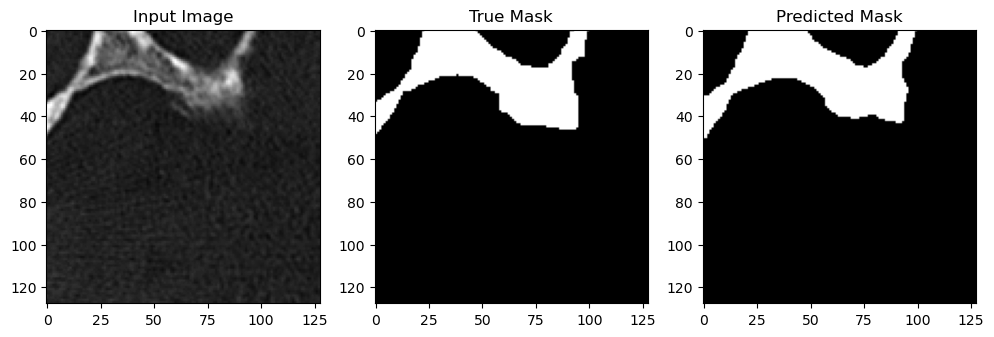

In [20]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

axes[0].imshow(test_original_3D[5,:,:,59,0], cmap='gray')
axes[0].set_title('Input Image')

axes[1].imshow(test_mask_3D[5,:,:,59,0], cmap='gray')
axes[1].set_title('True Mask')

axes[2].imshow(binary_vgg[5,:,:,59,0], cmap='gray')
axes[2].set_title('Predicted Mask')
    
plt.show()

In [30]:
vgg_patches_reshaped = np.reshape(binary_vgg[:,:,:,:,0],
                                        (4, 4, 1, 128, 128, 64))
vgg_reconstructed = unpatchify(vgg_patches_reshaped, (512,512,64))

In [32]:
for sample_idx in range(64):
    fig, axes = plt.subplots(1, 3, figsize=(12, 4))

    axes[0].imshow(reconstructed_original[:,:,sample_idx], cmap='gray')
    axes[0].set_title('Input Image')

    axes[1].imshow(reconstructed_mask[:,:,sample_idx], cmap='gray')
    axes[1].set_title('True Mask')

    axes[2].imshow(vgg_reconstructed[:,:,sample_idx], cmap='gray')
    axes[2].set_title('Predicted Mask')

    #save_dir = '/Users/yichunsun/Desktop/TFM/Data/3D/Results/PredictResult/vgg16' 
    save_dir = '/Users/yichunsun/Desktop/TFM/Data/3D/Results/PredictResult/Au_vgg16'
    os.makedirs(save_dir, exist_ok=True)

    plt.savefig(os.path.join(save_dir, f'Test_encoder_vgg16_slice_{sample_idx}.png'))
    plt.close()

In [31]:
D_vgg = dice_coefficient(reconstructed_mask, vgg_reconstructed)
print("DICE of using the vgg16 as encoder:", D_vgg)

DICE of using the vgg16 as encoder: 0.8943053287443915
